In [45]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from simple_fc import Encoder,Decoder
from cvae import Conditional_Variational_Autoencoder
from misc_ops import *

import numpy as np
import tensorflow as tf

from cs294_129.classifiers.pretrained_cnn import PretrainedCNN
from cs294_129.image_utils import preprocess_image#, blur_image, deprocess_image

from dataset import DataSet

from PIL import Image

from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
pre_trained_model = PretrainedCNN(h5_file='../networks/cs294_129/datasets/pretrained_model.h5')

# Train

In [72]:
tf.reset_default_graph()

In [42]:
# Training
sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = mnist.train,
                                            learning_rate = 0.001, num_epochs = 10,
                                           condition_on_label=True, model=pre_trained_model, layer=3,
                                            checkpoint_name = 'cvae_feats_checkpoint')
model.train()

Epoch 1 loss: 4033.4165989
Epoch 2 loss: 3578.95891335
Epoch 3 loss: 3521.36814409
Epoch 4 loss: 3488.95134322
Epoch 5 loss: 3466.49150879
Epoch 6 loss: 3450.35012873
Epoch 7 loss: 3437.64695091
Epoch 8 loss: 3427.97487749
Epoch 9 loss: 3420.0551598
Epoch 10 loss: 3413.45985174


In [73]:
# Load checkpoint
sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = mnist.train,
                                            learning_rate = 0.001, num_epochs = 10,
                                           condition_on_label=True, model=pre_trained_model, layer=3,
                                            load = True, load_file = 'checkpoints/cvae_feats_checkpoint',
                                            checkpoint_name = 'cvae_feats_checkpoint2')

In [ ]:
model.train()

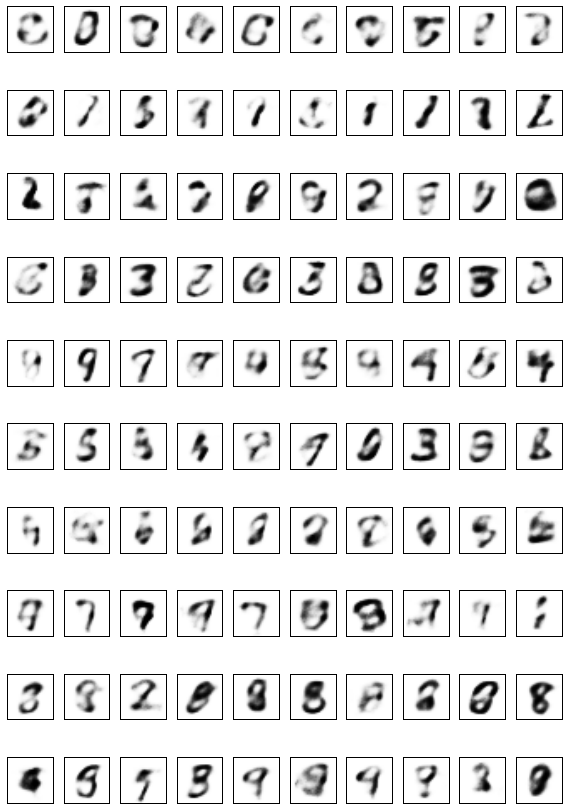

In [74]:
#images, info = mnist.test.next_batch(100)
num_examples = 10

info = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=100, info=info)
generated_images = generated_images[:, xrange(28*28)]

num_show = 5
plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig('images/by_label_feats')
plt.show()

In [ ]:
sess.close()
tf.reset_default_graph()